#시간대별 발생 패턴 기반 유사군 분류(clustering)

In [ ]:
# 1. 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
#. 나눔고딕 폰트 설치 (한글 폰트용)
!apt-get -qq install -y fonts-nanum
import matplotlib.pyplot as plt


Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib.font_manager as fm
# 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

In [ ]:
plt.rc('font', family='NanumGothic')  # 전역 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 2. 데이터 로드
df = pd.read_csv("전처리_시간대별_강력범죄_및_인구환경데이터.csv")

In [ ]:
# 3. 사용할 범죄유형 컬럼 정의
crime_columns = [
    '살인기수', '살인미수등', '강도', '강간', '유사강간', '강제추행',
    '기타 강간 강제추행등', '방화', '상해', '폭행', '체포 감금',
    '협박', '약취 유인', '폭력행위등', '공갈'
]

In [ ]:
# 4. 데이터 전처리: long → wide 형태로
df_melted = df[['시간대'] + crime_columns].melt(id_vars='시간대', var_name='범죄유형', value_name='발생건수')
pivot_df = df_melted.pivot_table(index='범죄유형', columns='시간대', values='발생건수').fillna(0)


In [ ]:
# 5. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df)


적절한 K 도출

In [ ]:
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

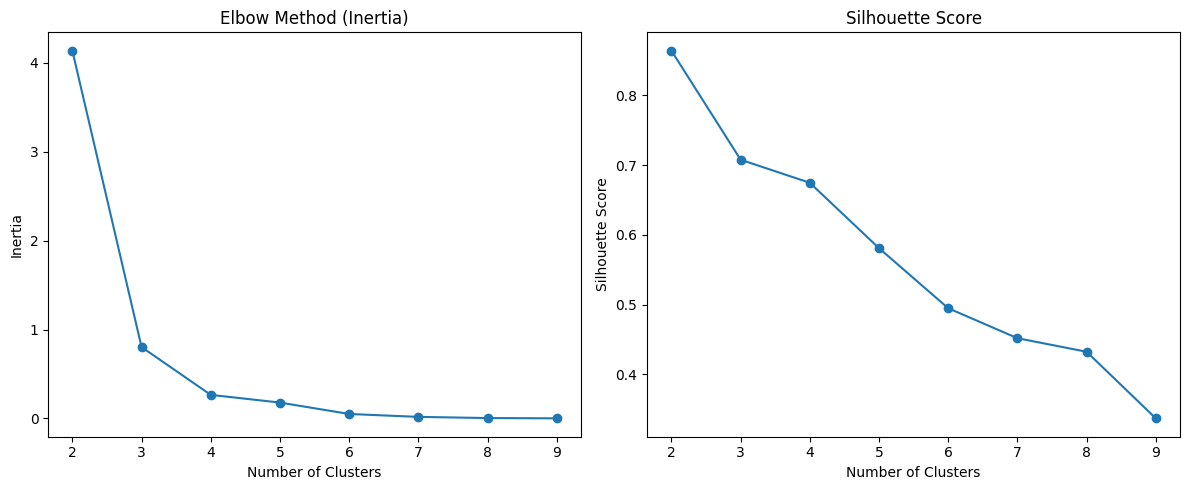

In [ ]:
# k 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

#[1] K-means Clustering

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pivot_df['KMeans_클러스터'] = kmeans.fit_predict(X_scaled)


In [ ]:
pivot_df[['KMeans_클러스터']]

시간대,KMeans_클러스터
범죄유형,
강간,0
강도,0
강제추행,2
공갈,0
기타 강간 강제추행등,0
방화,0
살인기수,0
살인미수등,0
상해,2


In [ ]:
# 클러스터별로 어떤 범죄유형들이 속했는지 확인
for cluster_num in sorted(pivot_df['KMeans_클러스터'].unique()):
    print(f"\n🟢 클러스터 {cluster_num} 에 속한 범죄유형:")
    print(pivot_df[pivot_df['KMeans_클러스터'] == cluster_num].index.tolist())


🟢 클러스터 0 에 속한 범죄유형:
['강간', '강도', '공갈', '기타 강간 강제추행등', '방화', '살인기수', '살인미수등', '약취 유인', '유사강간', '체포 감금', '폭력행위등']

🟢 클러스터 1 에 속한 범죄유형:
['폭행']

🟢 클러스터 2 에 속한 범죄유형:
['강제추행', '상해', '협박']


클러스터별 평균 시간대 분포 비교(시각화)

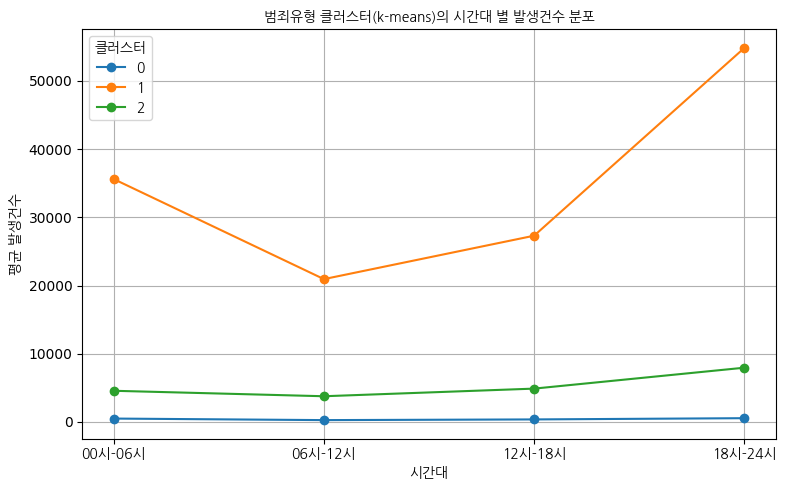

In [ ]:
# 시각화를 위해 클러스터 컬럼 제외한 부분만 선택
clustered_means = pivot_df.groupby('KMeans_클러스터').mean().drop(columns=['KMeans_클러스터'], errors='ignore')

# 꺾은선 그래프로 평균 분포 비교
clustered_means.T.plot(kind='line', marker='o', figsize=(8, 5))
plt.title("범죄유형 클러스터(k-means)의 시간대 별 발생건수 분포", fontproperties=font_prop)
plt.xlabel("시간대", fontproperties=font_prop)
plt.ylabel("평균 발생건수", fontproperties=font_prop)

# ✅ x축 라벨 수동 설정
plt.xticks(ticks=range(len(clustered_means.T.index)),
           labels=clustered_means.T.index.tolist(),
           fontproperties=font_prop)

plt.legend(title='클러스터', prop=font_prop, title_fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

#선형회귀
- 조도 vs. 범죄건수 산점도와 상관계수 분석
- 선형관계 존재 확인

In [ ]:
# 📌 1. 필요 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

In [ ]:
# 📌 3. 클러스터별 범죄유형 정의
cluster_0 = ['강간', '강도', '공갈', '기타 강간 강제추행등', '방화', '살인기수', '살인미수등', '약취 유인', '유사강간', '체포 감금', '폭력행위등']
cluster_1 = ['폭행']
cluster_2 = ['강제추행', '상해', '협박']
cluster_dict = {'클러스터0': cluster_0, '클러스터1': cluster_1, '클러스터2': cluster_2}

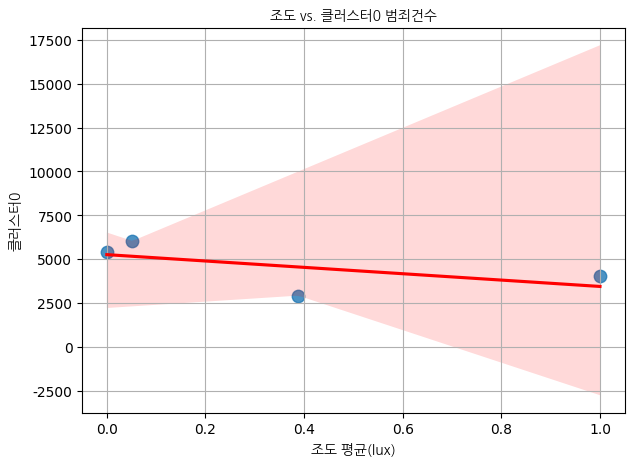

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



📊 [클러스터0] 선형 회귀 결과
 - 회귀 계수 (slope): -1809.794
 - 절편 (intercept): 5268.531
 - 결정계수 R²: 0.354
 - 예측 시뮬레이션:
   조도 0.2 → 예상 클러스터0 건수: 4906.6
   조도 0.4 → 예상 클러스터0 건수: 4544.6
   조도 0.6 → 예상 클러스터0 건수: 4182.7
   조도 0.8 → 예상 클러스터0 건수: 3820.7
   조도 1.0 → 예상 클러스터0 건수: 3458.7


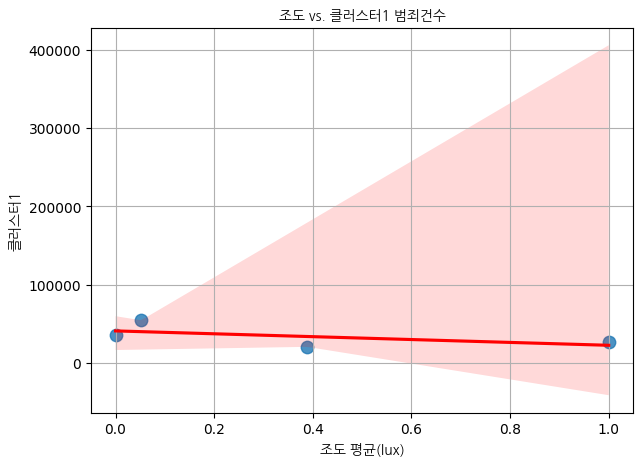

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



📊 [클러스터1] 선형 회귀 결과
 - 회귀 계수 (slope): -18344.635
 - 절편 (intercept): 41269.874
 - 결정계수 R²: 0.329
 - 예측 시뮬레이션:
   조도 0.2 → 예상 클러스터1 건수: 37600.9
   조도 0.4 → 예상 클러스터1 건수: 33932.0
   조도 0.6 → 예상 클러스터1 건수: 30263.1
   조도 0.8 → 예상 클러스터1 건수: 26594.2
   조도 1.0 → 예상 클러스터1 건수: 22925.2


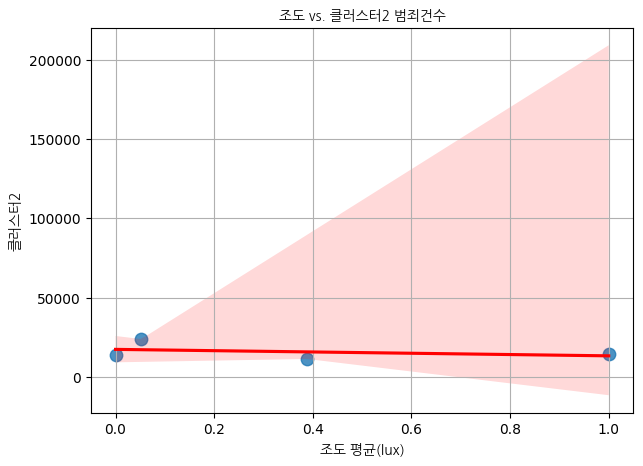


📊 [클러스터2] 선형 회귀 결과
 - 회귀 계수 (slope): -4071.198
 - 절편 (intercept): 17340.894
 - 결정계수 R²: 0.116
 - 예측 시뮬레이션:
   조도 0.2 → 예상 클러스터2 건수: 16526.7
   조도 0.4 → 예상 클러스터2 건수: 15712.4
   조도 0.6 → 예상 클러스터2 건수: 14898.2
   조도 0.8 → 예상 클러스터2 건수: 14083.9
   조도 1.0 → 예상 클러스터2 건수: 13269.7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
# 📌 4. 클러스터별 분석 반복
for name, crimes in cluster_dict.items():
    df[name] = df[crimes].sum(axis=1)

    # 회귀 분석
    X = df[['조도 평균(lux)']]
    y = df[name]
    model = LinearRegression()
    model.fit(X, y)
    pred = model.predict(X)
    r2 = model.score(X, y)

    # 시각화
    plt.figure(figsize=(7, 5))
    sns.regplot(x='조도 평균(lux)', y=name, data=df, scatter_kws={'s': 80}, line_kws={'color': 'red'})
    plt.title(f'조도 vs. {name} 범죄건수', fontsize=14, fontproperties=font_prop)
    plt.xlabel('조도 평균(lux)', fontproperties=font_prop)
    plt.ylabel(f'{name}', fontproperties=font_prop)
    plt.grid(True)
    plt.show()

    # 결과 출력
    print(f"\n📊 [{name}] 선형 회귀 결과")
    print(f" - 회귀 계수 (slope): {model.coef_[0]:.3f}")
    print(f" - 절편 (intercept): {model.intercept_:.3f}")
    print(f" - 결정계수 R²: {r2:.3f}")

    print(f" - 예측 시뮬레이션:")
    for lux in [0.2, 0.4, 0.6, 0.8, 1.0]:
        y_pred = model.predict([[lux]])[0]
        print(f"   조도 {lux:.1f} → 예상 {name} 건수: {y_pred:.1f}")

#[Random Forest 회귀: 클러스터0 대상]

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 📌 3. 클러스터0 범죄유형 정의 및 합계 생성
cluster_0 = ['강간', '강도', '공갈', '기타 강간 강제추행등', '방화', '살인기수', '살인미수등', '약취 유인', '유사강간', '체포 감금', '폭력행위등']
df['클러스터0'] = df[cluster_0].sum(axis=1)

# 📌 4. 사용할 Feature 정의
features = [
    '조도 평균(lux)', '소음 평균(dB)', '내국_총생활인구밀도',
    '시간대_내국_유소년', '시간대_내국_생산가능', '시간대_내국_고령',
    '시간대_외국_TEMP', '시간대_외국_LONG'
]

X = df[features]
y = df['클러스터0']

In [ ]:
# 📌 5. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 📌 6. Random Forest 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
# 📌 7. 예측 및 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 수정된 부분

print(f"\n📊 Random Forest 회귀 성능 (클러스터0)")
print(f" - 결정계수 R²: {r2:.3f}")
print(f" - RMSE(평균제곱근오차): {rmse:.2f}")


📊 Random Forest 회귀 성능 (클러스터0)
 - 결정계수 R²: 0.258
 - RMSE(평균제곱근오차): 1340.06


<ipython-input-51-f87d8a2f4a80>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


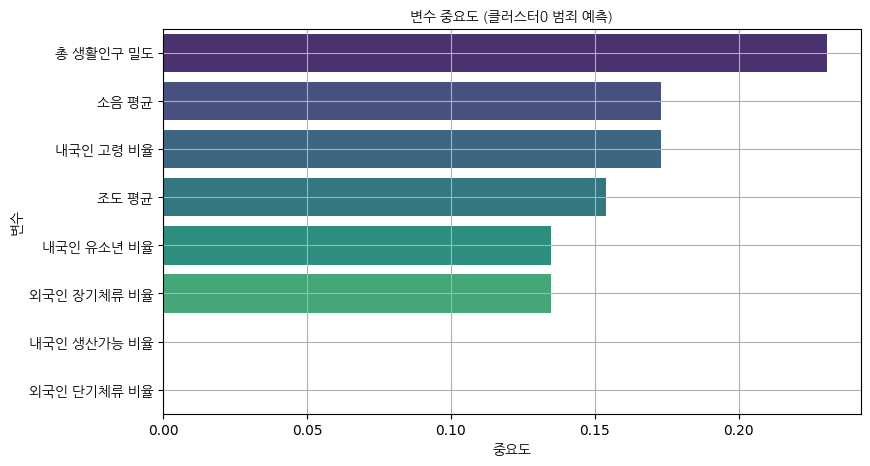

In [ ]:
# 📌 변수명을 한글로 변환하는 딕셔너리 정의
feature_kor = {
    '내국_총생활인구밀도': '총 생활인구 밀도',
    '소음 평균(dB)': '소음 평균',
    '조도 평균(lux)': '조도 평균',
    '시간대_내국_유소년': '내국인 유소년 비율',
    '시간대_내국_생산가능': '내국인 생산가능 비율',
    '시간대_내국_고령': '내국인 고령 비율',
    '시간대_외국_TEMP': '외국인 단기체류 비율',
    '시간대_외국_LONG': '외국인 장기체류 비율'
}

# 📌 변수 중요도 재설정 (한글 레이블로 매핑)
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=[feature_kor.get(col, col) for col in features])
feat_imp = feat_imp.sort_values(ascending=False)

# 📌 시각화
plt.figure(figsize=(9, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("변수 중요도 (클러스터0 범죄 예측)", fontproperties=font_prop)
plt.xlabel("중요도", fontproperties=font_prop)
plt.ylabel("변수", fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.grid(True)
plt.show()



🔍 클러스터1 분석 시작...

📊 Random Forest 회귀 성능 (클러스터1)
 - 결정계수 R²: 0.026
 - RMSE(평균제곱근오차): 16724.54


<ipython-input-53-6a706041a8e9>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


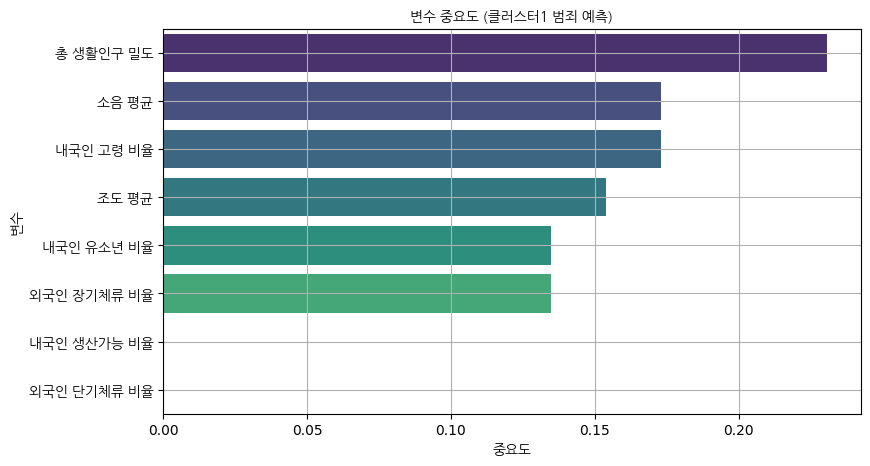


🔍 클러스터2 분석 시작...

📊 Random Forest 회귀 성능 (클러스터2)
 - 결정계수 R²: -0.349
 - RMSE(평균제곱근오차): 7289.12


<ipython-input-53-6a706041a8e9>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


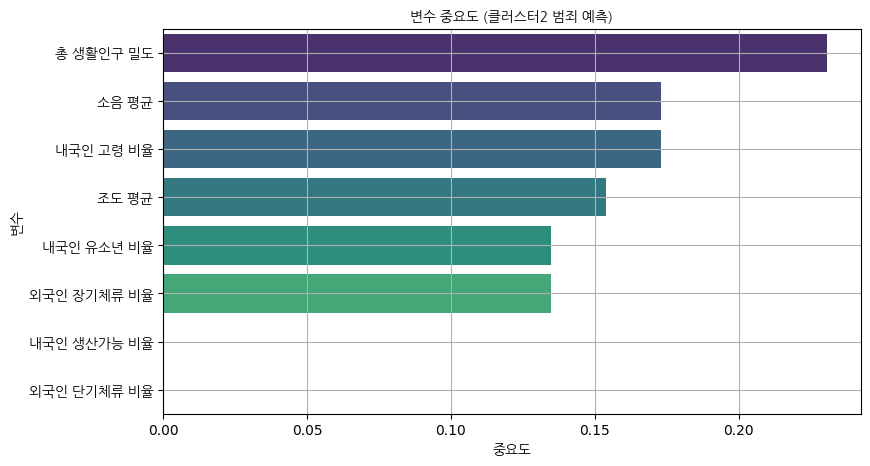

In [ ]:

# 📌 클러스터별 범죄유형 정의
cluster_dict = {
    '클러스터1': ['폭행'],
    '클러스터2': ['강제추행', '상해', '협박']
}

# 📌 입력 변수 정의
features = [
    '조도 평균(lux)', '소음 평균(dB)', '내국_총생활인구밀도',
    '시간대_내국_유소년', '시간대_내국_생산가능', '시간대_내국_고령',
    '시간대_외국_TEMP', '시간대_외국_LONG'
]

# 📌 변수명 한글 매핑
feature_kor = {
    '조도 평균(lux)': '조도 평균',
    '소음 평균(dB)': '소음 평균',
    '내국_총생활인구밀도': '총 생활인구 밀도',
    '시간대_내국_유소년': '내국인 유소년 비율',
    '시간대_내국_생산가능': '내국인 생산가능 비율',
    '시간대_내국_고령': '내국인 고령 비율',
    '시간대_외국_TEMP': '외국인 단기체류 비율',
    '시간대_외국_LONG': '외국인 장기체류 비율'
}

# 📌 클러스터별 반복 분석
for name, crimes in cluster_dict.items():
    print(f"\n🔍 {name} 분석 시작...\n")

    # 범죄 건수 합계 컬럼 생성
    df[name] = df[crimes].sum(axis=1)

    # 입력/타겟 변수
    X = df[features]
    y = df[name]

    # 학습/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"📊 Random Forest 회귀 성능 ({name})")
    print(f" - 결정계수 R²: {r2:.3f}")
    print(f" - RMSE(평균제곱근오차): {rmse:.2f}")

    # 변수 중요도 시각화
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=[feature_kor.get(col, col) for col in features]).sort_values(ascending=False)

    plt.figure(figsize=(9, 5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
    plt.title(f"변수 중요도 ({name} 범죄 예측)", fontproperties=font_prop)
    plt.xlabel("중요도", fontproperties=font_prop)
    plt.ylabel("변수", fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    plt.grid(True)
    plt.show()


<Figure size 600x400 with 0 Axes>

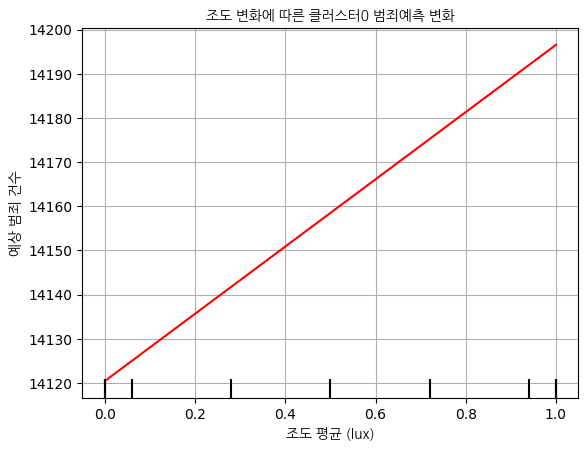

In [ ]:
# 📌 Partial Dependence Plot 그리기 위한 라이브러리
from sklearn.inspection import PartialDependenceDisplay

# 📌 조도만 단일 변수로 시각화
plt.figure(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    model,               # 클러스터0 학습된 Random Forest 모델
    X_train,             # 학습데이터
    features=['조도 평균(lux)'],  # 분석 대상 변수
    feature_names=features,
    grid_resolution=100,  # 곡선 부드럽게
    kind='average',
    line_kw={"color": "red"}
)
plt.title("조도 변화에 따른 클러스터0 범죄예측 변화", fontproperties=font_prop)
plt.xlabel("조도 평균 (lux)", fontproperties=font_prop)
plt.ylabel("예상 범죄 건수", fontproperties=font_prop)
plt.grid(True)
plt.show()


In [ ]:
for lux in [0.2, 0.4, 0.6, 0.8, 1.0]:
    temp = X_train.copy()
    temp['조도 평균(lux)'] = lux
    y_pred = model.predict(temp)
    print(f"조도 평균 {lux:.1f}일 때 예상 범죄 건수 평균: {np.mean(y_pred):.1f}건")


조도 평균 0.2일 때 예상 범죄 건수 평균: 14120.4건
조도 평균 0.4일 때 예상 범죄 건수 평균: 14120.4건
조도 평균 0.6일 때 예상 범죄 건수 평균: 14196.5건
조도 평균 0.8일 때 예상 범죄 건수 평균: 14196.5건
조도 평균 1.0일 때 예상 범죄 건수 평균: 14196.5건


#조도 개선의 범죄 완화 효과 분석 (선형회귀)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


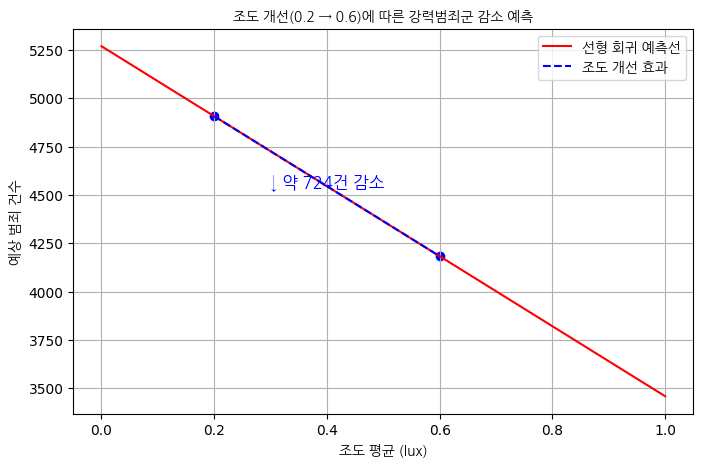

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 📌 선형 회귀 모델 재학습 (혹시 이전에 안 했을 수도 있으니 포함)
X_lin = df[['조도 평균(lux)']]
y_lin = df['클러스터0']
lin_model = LinearRegression()
lin_model.fit(X_lin, y_lin)

# 📌 조도 범위 만들기 (0.0 ~ 1.0)
lux_range = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred_range = lin_model.predict(lux_range)

# 📌 조도 0.2 → 0.6 변화에 대한 예측값 확인
y_02 = lin_model.predict([[0.2]])[0]
y_06 = lin_model.predict([[0.6]])[0]
diff = y_02 - y_06

# 📌 시각화
plt.figure(figsize=(8, 5))
plt.plot(lux_range, y_pred_range, color='red', label='선형 회귀 예측선')
plt.scatter([0.2, 0.6], [y_02, y_06], color='blue')
plt.plot([0.2, 0.6], [y_02, y_06], color='blue', linestyle='--', label='조도 개선 효과')

plt.text(0.4, (y_02 + y_06)/2, f"↓ 약 {diff:.0f}건 감소", fontsize=12, ha='center', color='blue', fontproperties=font_prop)

plt.title("조도 개선(0.2 → 0.6)에 따른 강력범죄군 감소 예측", fontproperties=font_prop)
plt.xlabel("조도 평균 (lux)", fontproperties=font_prop)
plt.ylabel("예상 범죄 건수", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.show()


In [ ]:
print(f"조도 0.2일 때 예측: {y_02:.1f}건")
print(f"조도 0.6일 때 예측: {y_06:.1f}건")
print(f"조도 개선 시 감소량: {diff:.1f}건")


조도 0.2일 때 예측: 4906.6건
조도 0.6일 때 예측: 4182.7건
조도 개선 시 감소량: 723.9건


#SHAP(Shapley Additive exPlanations) 분석
- 클러스터 0

In [ ]:
!pip install shap

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing 

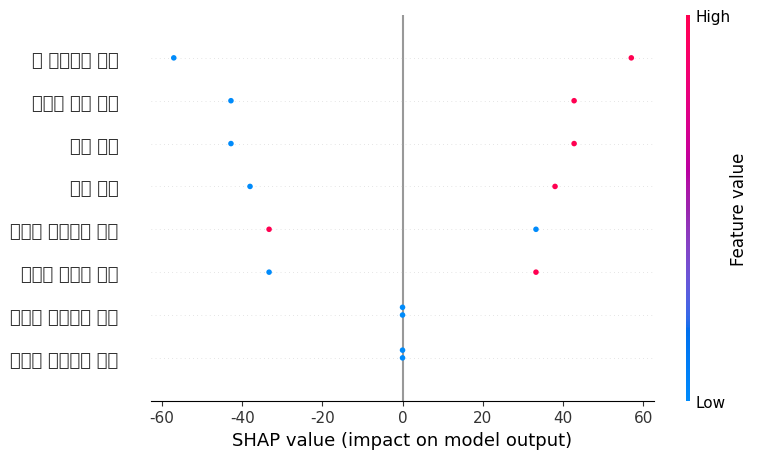

In [ ]:
import shap

# 📌 TreeExplainer로 모델 해석
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# 📌 요약 그래프 (Summary Plot): 변수별 영향력 시각화
shap.summary_plot(shap_values, X_train, feature_names=[
    '조도 평균', '소음 평균', '총 생활인구 밀도',
    '내국인 유소년 비율', '내국인 생산가능 비율',
    '내국인 고령 비율', '외국인 단기체류 비율', '외국인 장기체류 비율'
])
